In [1]:
from src.dl.loader import PatchDataset, PermutePatchDataset, splitDataset
import numpy as np
from torch.utils.data import ConcatDataset
from src.dl.resnet import ModifiedResNet18
from torch import nn
from torch.utils.data import DataLoader
import torch

In [2]:
net = ModifiedResNet18().cuda()

In [2]:
import os
import os.path
net = torch.load(os.path.join('data', 'bin', 'resnet50.pth'))

In [3]:
dataset = PatchDataset()
loss_fn = nn.SmoothL1Loss().cuda()
lr = 1e-3
optim = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.3)
#optim = torch.optim.Adam(net.parameters(), lr=lr, betas=[0.3, 0.1])
epoch = 200
dataloader = DataLoader(dataset, 64)

In [4]:
train_sets, test_set = splitDataset(6000, 5, dataset)
train_set = ConcatDataset(train_sets[1:])
validate_set = train_sets[0]
train_dataloader = DataLoader(train_set, batch_size=64, shuffle=True)
validate_dataloader = DataLoader(validate_set, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=64, shuffle=True)

In [6]:
losslist = []
for i in range(epoch):
    net.train()
    for step, [img, labels, score] in enumerate(train_dataloader):
        img = img.cuda()
        labels = labels.cuda()
        score = score.cuda()
        output = net(img, labels).squeeze(-1)
        loss = loss_fn(output.float(), score.float())
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        train_step = len(dataloader) * i + step + 1
        if train_step % 100 == 0:
            print("train time {}, loss {}".format(train_step, loss.item()))
            losslist.append(loss.item())

train time 100, loss 0.07350115478038788
train time 200, loss 0.09664015471935272
train time 300, loss 0.0777570903301239
train time 700, loss 0.08506564795970917
train time 800, loss 0.08689477294683456
train time 900, loss 0.08026859909296036
train time 1000, loss 0.06677034497261047
train time 1300, loss 0.07549749314785004
train time 1400, loss 0.06619927287101746
train time 1500, loss 0.06118018925189972
train time 1600, loss 0.057472389191389084
train time 2000, loss 0.05070580542087555
train time 2100, loss 0.04220855236053467
train time 2200, loss 0.03390132635831833
train time 2300, loss 0.028178229928016663
train time 2600, loss 0.031917545944452286
train time 2700, loss 0.03009837493300438
train time 2800, loss 0.02638271450996399
train time 2900, loss 0.03424285724759102
train time 3300, loss 0.036901265382766724
train time 3400, loss 0.0232691653072834
train time 3500, loss 0.028894413262605667
train time 3600, loss 0.024467526003718376
train time 3900, loss 0.020892679691

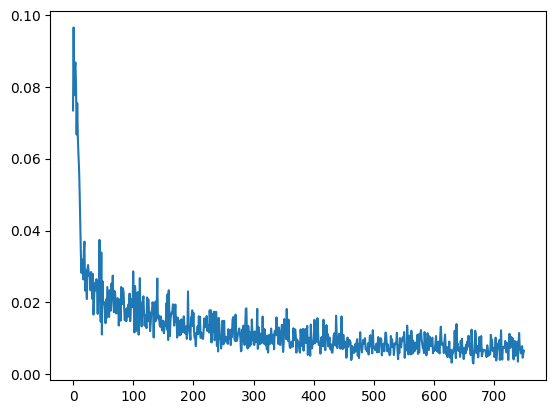

In [7]:
from matplotlib import pyplot as plt

plt.plot(losslist)

In [5]:
net.eval()
test_loss = 0
sum_gap = 0
avg_gap = 0
count = 0
predy = []
y = []
with torch.no_grad():
    for img, labels, score in validate_dataloader:
        img = img.cuda()
        labels = labels.cuda()
        score = score.cuda()
        output = net(img, labels).squeeze(-1)
        loss = loss_fn(output.float(), score.float())
        test_loss += loss.item()
        #print(loss.item())
        sum_gap += np.sum(np.abs(output.cpu().numpy() - score.cpu().float().numpy()))
        predy.extend(list(output.cpu().numpy()))
        y.extend(list(score.cpu().float().numpy()))
print(test_loss)
predy = np.array(predy)
y = np.array(y)
avgy = np.average(y)
num = np.sum((y - predy) ** 2)
den = np.sum((y - avgy) ** 2)
r = 1 - (num / den)
print(r)
mse = ((y - predy) ** 2).mean()
print(mse)
mae = np.abs(y - predy).mean()
print(mae)

1.7828708793967962
0.1865004301071167
0.037888993
0.14580497


In [28]:
y = []
for img, labels, score in validate_dataloader:
    y.extend(list(score.float().numpy()))
meany = np.mean(y)
mse = ((y - meany) ** 2).mean()
print(mse)
mae = np.abs(y - meany).mean()
print(mae)

0.046575308
0.17479366


In [20]:
indices = validate_set.indices
permuted_set = PermutePatchDataset(indices)
loss_list = []
r_list = []
mse_list = []
mae_list = []
loop = 1000

In [21]:
for i in range(loop):
    permuted_set.permute()
    permuted_dataloader = DataLoader(permuted_set, batch_size=64, shuffle=True)
    net.eval()
    test_loss = 0
    sum_gap = 0
    avg_gap = 0
    count = 0
    predy = []
    y = []
    with torch.no_grad():
        for img, labels, score in permuted_dataloader:
            img = img.cuda()
            labels = labels.cuda()
            score = score.cuda()
            output = net(img, labels).squeeze(-1)
            loss = loss_fn(output.float(), score.float())
            test_loss += loss.item()
            #print(loss.item())
            sum_gap += np.sum(np.abs(output.cpu().numpy() - score.cpu().float().numpy()))
            predy.extend(list(output.cpu().numpy()))
            y.extend(list(score.cpu().float().numpy()))
    #print(test_loss)
    predy = np.array(predy)
    y = np.array(y)
    avgy = np.average(y)
    num = np.sum((y - predy) ** 2)
    den = np.sum((y - avgy) ** 2)
    r = 1 - (num / den)
    #print(r)
    mse = ((y - predy) ** 2).mean()
    #print(mse)
    mae = np.abs(y - predy).mean()
    #print(mae)
    loss_list.append(loss.item())
    r_list.append(r)
    mse_list.append(mse)
    mae_list.append(mae)
    print('loop {}, loss {}, r {}, mse {}, mae {}'.format(i, test_loss, r, mse, mae))

loop 0, loss 4.0040657836943865, r -0.9742832183837891, mse 0.08516008406877518, mae 0.23472179472446442
loop 1, loss 3.6885517947375774, r -0.8194272518157959, mse 0.07848041504621506, mae 0.2254510521888733
loop 2, loss 3.740258613601327, r -0.8447602987289429, mse 0.0795731469988823, mae 0.2277127504348755
loop 3, loss 3.771485600620508, r -0.8600574731826782, mse 0.08023299276828766, mae 0.22850430011749268
loop 4, loss 3.732031974941492, r -0.8421974182128906, mse 0.07946260273456573, mae 0.22736555337905884
loop 5, loss 3.826086947694421, r -0.8853540420532227, mse 0.08132415264844894, mae 0.23014189302921295
loop 6, loss 3.7567926328629255, r -0.8528145551681519, mse 0.07992057502269745, mae 0.2274155616760254
loop 7, loss 3.7746441178023815, r -0.8636218309402466, mse 0.08038673549890518, mae 0.22835510969161987
loop 8, loss 3.8051191568374634, r -0.8775961399078369, mse 0.08098951727151871, mae 0.22831884026527405
loop 9, loss 3.8162033148109913, r -0.8822641372680664, mse 0.0

In [23]:
np.array(mse_list) < 0.03789

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,